In [14]:
import numpy as np
from numpy import ma
import math
import scipy
import os
from IPython.display import Image

from netCDF4 import Dataset

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker

# from matplotlib.mlab import bivariate_normal

In [5]:
FILEDIR2 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/gc_2x25_lagrange'
NcFile2   = Dataset(FILEDIR2+'/OutputDir/GEOSChem.SpeciesConc.201501_02.nc4','r',format='NETCDF4_CLASSIC')

NA = 6.022e+23

lat             = NcFile2.variables['lat'][:]
lon             = NcFile2.variables['lon'][:]
LA_3            = NcFile2.variables['SpeciesConc_PASV_LA3'][:,:,:,:]
LA              = NcFile2.variables['SpeciesConc_PASV_LA']

LA = LA + LA_3

GC_AREA = NcFile2.variables['AREA']


# 
FILEDIR1 = '/n/home12/hongwei/HONGWEI/GC_run_13.0/1_plume_in_60deg/gc_2x25_eulerian'
NcFile1   = Dataset(FILEDIR1+'/OutputDir/GEOSChem.SpeciesConc.201501_02.nc4','r',format='NETCDF4_CLASSIC')

NA = 6.022e+23

EU              = NcFile1.variables['SpeciesConc_PASV_EU']

In [6]:
#------------------------------------------------
# total air mass in each grid  ------------------
#------------------------------------------------

AD_file = open(FILEDIR2+'/State_Met_AD.txt','r')

GC_AD = EU[0,:,:,:]*0.0

Nx = len(EU[0,0,0,:])
Ny = len(EU[0,0,:,0])
Nz = len(EU[0,:,0,0])
Nt = len(EU[:,0,0,0])

for ix in range(Nx):
    for iy in range(Ny):
        for iz in range(Nz):
            line = AD_file.readline()
            GC_AD[iz,iy,ix] = float(line)

In [7]:
### change unit, do average

EU2 = EU[:,:,:,:]*0.0
for i in range(len(EU[:,0,0,0])):
    EU2[i,:,:,:] = EU[i,:,:,:]*(GC_AD[:,:,:]*1000.0/28.97)*NA # [mol/mol] to [molec]
    

EU_Zsum = np.sum(EU2[:,:,:,:], axis=1)
for i in range(len(EU[:,0,0,0])):
    EU_Zsum[i,:,:] = EU_Zsum[i,:,:]/GC_AREA[:,:]/1e4 # [molec/cm2]

EU_Zsum_Xmean = np.mean(EU_Zsum[:,:,:], axis=2)



LA2 = LA[:,:,:,:]*0.0
for i in range(len(LA[:,0,0,0])):
    LA2[i,:,:,:] = LA[i,:,:,:]*(GC_AD[:,:,:]*1000.0/28.97)*NA


LA_Zsum = np.sum(LA2[:,:,:,:], axis=1)
for i in range(len(LA[:,0,0,0])):
    LA_Zsum[i,:,:]   = LA_Zsum[i,:,:]/GC_AREA[:,:]/1e4

LA_Zsum_Xmean = np.mean(LA_Zsum[:,:,:], axis=2)

t = len(EU[:,0,0,0])-1
print(f'Total mass [molec] in the end: GEOS-Chem={np.sum(EU2[-1,:,:,:])}, plume model={np.sum(LA2[-1,:,:,:])}')

Total mass [molec] in the end: GEOS-Chem=1.1191467570096782e+30, plume model=1.1080417155464256e+30


[1.1196148e+30,
 1.1195979e+30,
 1.1195745e+30,
 1.1190502e+30,
 1.11874214e+30,
 1.1184432e+30,
 1.11849424e+30,
 1.1179339e+30,
 1.1179988e+30,
 1.1168648e+30,
 1.11579486e+30,
 1.1145792e+30,
 1.1136297e+30,
 1.1125002e+30,
 1.1111654e+30,
 1.1095558e+30,
 1.1080398e+30,
 1.10803945e+30,
 1.1080397e+30,
 1.1080396e+30,
 1.1080395e+30,
 1.1080395e+30,
 1.1080397e+30,
 1.1080396e+30,
 1.1080397e+30,
 1.1080395e+30,
 1.10803975e+30,
 1.1080397e+30,
 1.1080396e+30,
 1.1080396e+30,
 1.10803945e+30,
 1.1080399e+30,
 1.1080404e+30,
 1.1080404e+30,
 1.10804126e+30,
 1.108042e+30,
 1.10804164e+30,
 1.10804066e+30,
 1.1080402e+30,
 1.1080403e+30,
 1.1080406e+30,
 1.1080406e+30,
 1.1080405e+30,
 1.10804066e+30,
 1.1080415e+30,
 1.1080412e+30,
 1.1080414e+30,
 1.1080413e+30,
 1.1080417e+30,
 1.1080421e+30,
 1.1080418e+30,
 1.10804164e+30,
 1.108042e+30,
 1.1080407e+30,
 1.10804126e+30,
 1.108041e+30,
 1.108042e+30,
 1.108042e+30,
 1.1080417e+30]

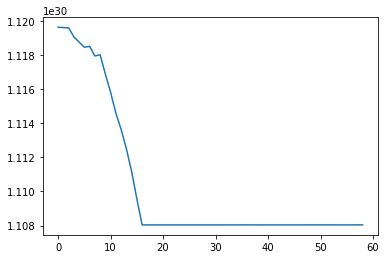

In [8]:
Total_mass1, Total_mass2 = [],[]
for i in range(Nt):
    Total_mass1.append( np.sum(LA2[i,:,:,:]) )
    Total_mass2.append( np.sum(EU2[i,:,:,:]) )
    

plt.plot(Total_mass1);
# plt.plot(Total_mass2);
Total_mass1

In [9]:
lon_cyc = list(lon)
lon_cyc.append(180)
lon_cyc = np.array(lon_cyc)

In [10]:
# plot  -----------------------------------------
#------------------------------------------------

# time step for ploting is 24 hours (once every day)
print(Nt)


i=0
while i<Nt:
    print(i)
    fig = plt.figure(figsize=(16,8));
#     gs = fig.add_gridspec(15, 8)
    plt.suptitle('Day: '+str(i+1), fontsize=16);
    
    
    
    # for Lagrange ============================================================
    projection=ccrs.PlateCarree()
    ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree());
    ax1.set_global()
    
    ax1.gridlines(x_inline=True)    
    ax1.set_xticks(np.linspace(-180, 180, 7), crs=projection)
    ax1.set_yticks(np.linspace(-90, 90, 7), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    

#     z = ma.masked_where(LA_Zsum[i,:,:] <= 1e-10, LA_Zsum[i,:,:])

    ratio = 2.5e-2
    levels = [0.01e12,0.05e12,0.1e12, 0.5e12, 1e12, 5e12, 10e12]
    levels = np.array(levels)*ratio
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)
    

    data = LA_Zsum[i,:,:]
    cyclic_data = add_cyclic_point(data)
    data, lon_cyclic = add_cyclic_point(data, coord=lon)

    ax1_contours = ax1.contourf(lon_cyclic, lat, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("Reds"), extend="max");
    
    cb1 = plt.colorbar(ax1_contours, ax=ax1)
    cb1.ax.tick_params(labelsize=11)
    
    ax1.coastlines();
    ax1.set_title('Lagrangian (2*2.5)', fontsize=11);


    
    # for Lagrange Distribution: ==============================================
    ax2 = plt.subplot(2,2,2);
    
    ax2.plot(LA_Zsum_Xmean[i,:], lat, 'r-', label='2*2.5');

    X_max = 1e+12;
    ax2.set_xlim(0,X_max);
    ax2.set_ylim(-90,90);
    ax2.set_ylabel('Latitude (deg)');
    ax2.tick_params(axis='x', labelsize=11)  # to Set Matplotlib Tick Labels Font Size
    ax2.tick_params(axis='y', labelsize=11)
    ax2.legend();
    ax2.set_title('Lagrangian', fontsize=11);
    
    
    
#     levels = np.array(levels)*1e-3 
#     norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

     # for EU ==================================================================
    ax3 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree());
    ax3.set_global()
    
    ax3.gridlines(x_inline=True)    
    ax3.set_xticks(np.linspace(-180, 180, 7), crs=projection)
    ax3.set_yticks(np.linspace(-90, 90, 7), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax3.xaxis.set_major_formatter(lon_formatter)
    ax3.yaxis.set_major_formatter(lat_formatter)
    
#     z = ma.masked_where(EU_Zsum[i,:,:] <= 1e-5, EU_Zsum[i,:,:])
    data = EU_Zsum[i,:,:]
    cyclic_data = add_cyclic_point(data)
    data, lon_cyclic = add_cyclic_point(data, coord=lon)
    
    ax3_contours = ax3.contourf(lon_cyclic, lat, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("Reds"), extend="max");


    cb3 = plt.colorbar(ax3_contours, ax=ax3)
    cb3.ax.tick_params(labelsize=11)
    
    ax3.coastlines();
    ax3.set_title('Eulerian (2*2.5)', fontsize=11);
    
    
    
    # for GOES distribution ===================================================
    
    ax4 = plt.subplot(2,2,4);
    
    ax4.plot(EU_Zsum_Xmean[i,:], lat, 'r-', label='2*2.5');

#     ax4.set_xscale('log')

    ax4.set_xlim(0,X_max);
    ax4.set_ylim(-90,90);
    ax4.set_xlabel('Tracer Concentration [molec/cm2]');
    ax4.set_ylabel('Latitude (deg)');
    ax4.tick_params(axis='x', labelsize=11)  # to Set Matplotlib Tick Labels Font Size
    ax4.tick_params(axis='y', labelsize=11)
    ax4.legend()
    ax4.set_title('Eulerian', fontsize=11);
    
    
    plt.tight_layout()
    plt.savefig(str(i+1)+'_xy2.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
    
    i = i + 1;
    
plt.close();


59
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58


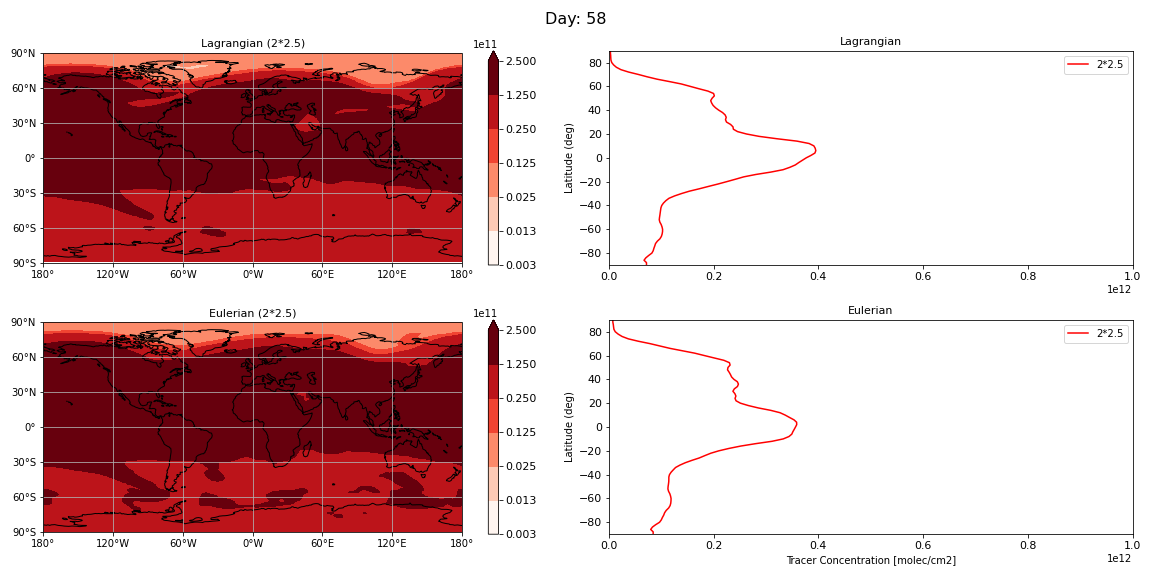

In [11]:
Image(filename=f'{Nt-1}_xy2.png')

In [15]:
os.system("./png2gif2.sh")

32512